In [1]:
%matplotlib inline
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
from CMS_SURF_2016.utils.archiving import get_trials_by_name, get_all_data, DataProcedure, KerasTrial
from CMS_SURF_2016.layers.slice import Slice
from CMS_SURF_2016.layers.lorentz import Lorentz
from CMS_SURF_2016.utils.analysistools import *
from CMS_SURF_2016.utils.plot import *
from CMS_SURF_2016.utils.metrics import accVsEventChar
from keras.utils.visualize_util import plot
from IPython.display import Image, display
import numpy as np
archive_dir = "/data/shared/Delphes/old_keras_archive/"


Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def sortOnMetric(trials,sortMetric='test_acc'):
    def getKey(trial):
        return trial.get_from_record(sortMetric)
    trials.sort(key=getKey, reverse=True)
    return trials

trials = get_trials_by_name(".", archive_dir)
print(trials)
trials = sortOnMetric(trials)

[<CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687b8cd0>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687b8d90>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687b8e50>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687b8f10>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687b8fd0>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d20d0>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d2190>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d2250>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d2310>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d23d0>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d2490>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d2590>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d2610>, <CMS_SURF_2016.utils.archiving.KerasTrial object at 0x7fc3687d26d0>, <CMS_SURF_2016.utils.archiving.Ke

In [3]:
trials = get_trials_by_name("lorentz", archive_dir)

trial = KerasTrial.find_by_hashcode(archive_dir, "48acbcf67d395c1ad08261c259a166e2dcde2460")
trial.summary()
#trial.hashcode = "48acbcf67d395c1ad08261c259a166e2dcde2460"

print(type(trial.val_procedure))

--------------------------------------------------
TRIAL SUMMARY (48acbcf67d395c1ad08261c259a166e2dcde2460)
    Record_Info:
        name = lorentz, elapse_time = 0:16:56, fit_cycles = 1
        test_acc = 0.8334, val_acc = 0.9518, test_loss = 0.4010
        num_train = 177632, num_validation = 38064, num_test = 38064
        activation = relu, depth = 2, dropout = 0.0, lables = [u'ttbar', u'wjet'], sphereCoords = True, width = 100
--------------------------------------------------
<type 'list'>


In [4]:
model = trial.compile(loadweights=True,custom_objects={"Lorentz": Lorentz, "Slice" : Slice})

p = DataProcedure.from_json(archive_dir,trial.val_procedure[0])
#print(p)
#print(trial.nb_val_samples)
gen = p.getData()
#predictions = model.predict_generator(, trial.nb_val_samples)

Generating DataProcedure in range(88816,107848):
   From 2 labels in range(88816,98816) for 2x10000 = 20000 Samples
   From 2 labels in range(98816,107848) for 2x9032 = 18064 Samples


In [5]:
num_sample = trial.nb_val_samples
num_read = 0
correct = 0
batch_metrics = None
num_batches = None
global_batch_size = None

for i,(X,Y) in enumerate(gen):
    batch_size = Y[0].shape[0] if isinstance(Y, list) else Y.shape[0]
    m = model.test_on_batch(X,Y)
    if(batch_metrics == None):
        global_batch_size = batch_size
        num_batches =  np.ceil(num_sample/float(global_batch_size))
        batch_metrics = [None] * num_batches
    batch_metrics[i] = m
    num_read += batch_size
    if(num_read >= num_sample):
        break

batch_metrics = np.array(batch_metrics)
avg = np.mean(batch_metrics, axis=0, dtype='float64')
sem = np.std(batch_metrics, axis=0, dtype='float64')/np.sqrt(num_batches)
print("Average:", avg)
print("SEM:", sem)


DataProcedure results '19fda7d0d7a3396f067af45bd0cea16c3d927fc0' read from archive
DataProcedure results '75498727e6823e3f8b73509e1bc90c72574af42f' read from archive
('Average:', array([ 0.18301594,  0.95001394]))
('SEM:', array([ 0.00498322,  0.00107539]))


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
trial.summary()

--------------------------------------------------
TRIAL SUMMARY (48acbcf67d395c1ad08261c259a166e2dcde2460)
    Record_Info:
        name = lorentz, elapse_time = 0:16:56, fit_cycles = 1
        test_acc = 0.8334, val_acc = 0.9518, test_loss = 0.4010
        num_train = 177632, num_validation = 38064, num_test = 38064
        activation = relu, depth = 2, dropout = 0.0, lables = [u'ttbar', u'wjet'], sphereCoords = True, width = 100
--------------------------------------------------


--------------------------------------------------
TRIAL SUMMARY (48acbcf67d395c1ad08261c259a166e2dcde2460)
    Record_Info:
        name = lorentz, elapse_time = 0:16:56, fit_cycles = 1
        test_acc = 0.8334, val_acc = 0.9518, test_loss = 0.4010
        num_train = 177632, num_validation = 38064, num_test = 38064
        activation = relu, depth = 2, dropout = 0.0, lables = [u'ttbar', u'wjet'], sphereCoords = True, width = 100
--------------------------------------------------
Generating DataProcedure in range(88816,107848):
   From 2 labels in range(88816,98816) for 2x10000 = 20000 Samples
   From 2 labels in range(98816,107848) for 2x9032 = 18064 Samples
['Electron', 'MuonTight', 'Photon', 'MissingET', 'EFlowPhoton', 'EFlowNeutralHadron', 'EFlowTrack']
['EFlowPhoton', 'EFlowNeutralHadron', 'EFlowTrack']
DataProcedure results '19fda7d0d7a3396f067af45bd0cea16c3d927fc0' read from archive
DataProcedure results '75498727e6823e3f8b73509e1bc90c72574af42f' read from archive
(38064, 3806

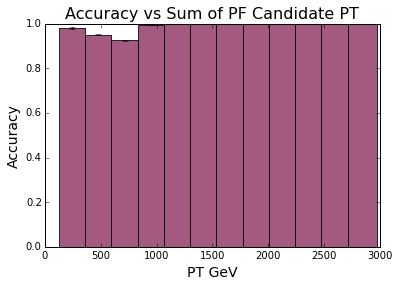

--------------------------------------------------
TRIAL SUMMARY (195b7fab0e8199a3185d093756bcd35b2bc63081)
    Record_Info:
        name = lorentz, elapse_time = 0:27:01, fit_cycles = 1
        test_acc = 0.7429, val_acc = 0.7450, test_loss = 0.5292
        num_train = 177632, num_validation = 38064, num_test = 38064
        activation = relu, depth = 2, dropout = 0.0, lables = [u'qcd', u'ttbar'], sphereCoords = False, width = 10
--------------------------------------------------
Generating DataProcedure in range(88816,107848):
   From 2 labels in range(88816,98816) for 2x10000 = 20000 Samples
   From 2 labels in range(98816,107848) for 2x9032 = 18064 Samples
['Electron', 'MuonTight', 'Photon', 'MissingET', 'EFlowPhoton', 'EFlowNeutralHadron', 'EFlowTrack']
['EFlowPhoton', 'EFlowNeutralHadron', 'EFlowTrack']
DataProcedure results 'e4b6448cd4c3b13faea5ea0e6e158f4fabc15e40' read from archive
DataProcedure results '3122dc98b5576cf48557b3426b27addddf37d61d' read from archive
(38064, 38064

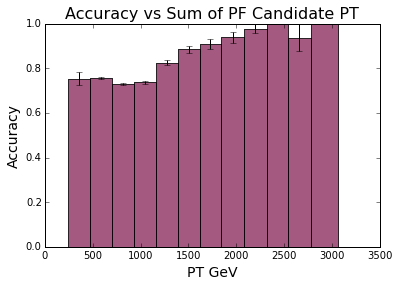

In [10]:
trial1 = KerasTrial.find_by_hashcode(archive_dir, "48acbcf67d395c1ad08261c259a166e2dcde2460")
trial2 = KerasTrial.find_by_hashcode(archive_dir, "195b7fab0e8199a3185d093756bcd35b2bc63081")

def plotTrial(trial):
    trial.summary()
    model = trial.compile(loadweights=True,custom_objects={"Lorentz": Lorentz, "Slice" : Slice})
    p = DataProcedure.from_json(archive_dir,trial.val_procedure[0])
    gen = p.getData()            
    d = accVsEventChar(model, gen, np.sum, "PT_ET", ["EFlowPhoton","EFlowNeutralHadron","EFlowTrack"],
                       #This is the  possible_observables ordering of the old parsing format. 
                       possible_observables =['E/c', 'Px', 'Py', 'Pz', 'Charge', 'PT_ET'],
                       num_samples=trial.nb_val_samples, equalBins=False)        
    plotBins(d,title='Accuracy vs Sum of PF Candidate PT', xlabel="PT GeV", ylabel='Accuracy', color=(0.553,0.188,0.38))  

plotTrial(trial1)
plotTrial(trial2)
        
    

In [8]:
[ 0.009051    0.00619716]
[ 0.00876452  0.0061347 ]


SyntaxError: invalid syntax (<ipython-input-8-50770436ab1e>, line 1)